# softmax回归的简洁实现

在[线性回归的框架实现](https://github.com/lixinjie97/Deep_learning_tutorial/blob/main/02.linear-networks/03.linear-regression-concise.ipynb)中，我们发现(**通过深度学习框架的高级API能够实现**)线性回归而且更加容易。同样，通过深度学习框架的高级API也能更方便地实现softmax回归模型。本节和[softmax回归的源码实现](https://github.com/lixinjie97/Deep_learning_tutorial/blob/main/02.linear-networks/06.softmax-regression-scratch.ipynb)中一样，继续使用Fashion-MNIST数据集，并保持批量大小为256。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

如我们在[softmax回归](https://github.com/lixinjie97/Deep_learning_tutorial/blob/main/02.linear-networks/04.softmax-regression.ipynb)所述，
[**softmax回归的输出层是一个全连接层**]。
因此，为了实现我们的模型，
我们只需在`Sequential`中添加一个带有10个输出的全连接层。
同样，在这里`Sequential`并不是必要的，
但它是实现深度模型的基础。
我们仍然以均值0和标准差0.01随机初始化权重。

In [3]:
# PyTorch不会隐式地调整输入的形状。因此
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

## 重新审视Softmax的实现

在前面[softmax回归的源码实现](https://github.com/lixinjie97/Deep_learning_tutorial/blob/main/02.linear-networks/06.softmax-regression-scratch.ipynb)的例子中，
我们计算了模型的输出，然后将此输出送入交叉熵损失。
从数学上讲，这是一件完全合理的事情。
然而，从计算角度来看，指数可能会造成数值稳定性问题。

回想一下，softmax函数$\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$，
其中$\hat y_j$是预测的概率分布。
$o_j$是未规范化的预测$\mathbf{o}$的第$j$个元素。
如果$o_k$中的一些数值非常大，
那么$\exp(o_k)$可能大于数据类型容许的最大数字，即*上溢*（overflow）。
这将使分母或分子变为`inf`（无穷大），
最后得到的是0、`inf`或`nan`（不是数字）的$\hat y_j$。
在这些情况下，我们无法得到一个明确定义的交叉熵值。

解决这个问题的一个技巧是：
在继续softmax计算之前，先从所有$o_k$中减去$\max(o_k)$。
这里可以看到每个$o_k$按常数进行的移动不会改变softmax的返回值：

$$
\begin{aligned}
\hat y_j & =  \frac{\exp(o_j - \max(o_k))\exp(\max(o_k))}{\sum_k \exp(o_k - \max(o_k))\exp(\max(o_k))} \\
& = \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}.
\end{aligned}
$$


在减法和规范化步骤之后，可能有些$o_j - \max(o_k)$具有较大的负值。
由于精度受限，$\exp(o_j - \max(o_k))$将有接近零的值，即*下溢*（underflow）。
这些值可能会四舍五入为零，使$\hat y_j$为零，
并且使得$\log(\hat y_j)$的值为`-inf`。
反向传播几步后，我们可能会发现自己面对一屏幕可怕的`nan`结果。

尽管我们要计算指数函数，但我们最终在计算交叉熵损失时会取它们的对数。
通过将softmax和交叉熵结合在一起，可以避免反向传播过程中可能会困扰我们的数值稳定性问题。
如下面的等式所示，我们避免计算$\exp(o_j - \max(o_k))$，
而可以直接使用$o_j - \max(o_k)$，因为$\log(\exp(\cdot))$被抵消了。

$$
\begin{aligned}
\log{(\hat y_j)} & = \log\left( \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}\right) \\
& = \log{(\exp(o_j - \max(o_k)))}-\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)} \\
& = o_j - \max(o_k) -\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)}.
\end{aligned}
$$

我们也希望保留传统的softmax函数，以备我们需要评估通过模型输出的概率。
但是，我们没有将softmax概率传递到损失函数中，
而是[**在交叉熵损失函数中传递未规范化的预测，并同时计算softmax及其对数**]，
这是一种类似["LogSumExp技巧"](https://en.wikipedia.org/wiki/LogSumExp)的聪明方式。


In [4]:
loss = nn.CrossEntropyLoss(reduction='none')

## 优化算法

在这里，我们(**使用学习率为0.1的小批量随机梯度下降作为优化算法**)。
这与我们在线性回归例子中的相同，这说明了优化器的普适性。

In [5]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

## 训练

接下来我们[**调用**] [softmax回归的源码实现](https://github.com/lixinjie97/Deep_learning_tutorial/blob/main/02.linear-networks/06.softmax-regression-scratch.ipynb)中(~~之前~~)
(**定义的训练函数来训练模型**)。

(**报错需要降低d2l的版本pip install d2l==0.17.5 --user**)。

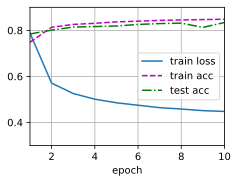

In [6]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

和以前一样，这个算法使结果收敛到一个相当高的精度，而且这次的代码比之前更精简了。

## 小结

* 使用深度学习框架的高级API，我们可以更简洁地实现softmax回归。
* 从计算的角度来看，实现softmax回归比较复杂。在许多情况下，深度学习框架在这些著名的技巧之外采取了额外的预防措施，来确保数值的稳定性。这使我们避免了在实践中从零开始编写模型时可能遇到的陷阱。

## 练习

1. 尝试调整超参数，例如批量大小、迭代周期数和学习率，并查看结果。
1. 增加迭代周期的数量。为什么测试精度会在一段时间后降低？我们怎么解决这个问题？
1. 为什么要使用LogSumExp，请详细解释一下。
https://blog.csdn.net/yjw123456/article/details/121869249

### 练习一

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# PyTorch不会隐式地调整输入的形状。因此
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [3]:
# 设置损失函数
loss = nn.CrossEntropyLoss(reduction='none')

# 设置优化器
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

CPU times: user 1min 21s, sys: 9.91 s, total: 1min 31s
Wall time: 14 s


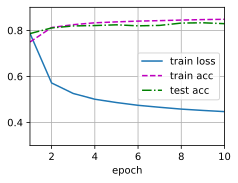

In [4]:
%%time
num_epochs = 10
batch_size = 256

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

CPU times: user 15min 2s, sys: 1min 55s, total: 16min 58s
Wall time: 2min 34s


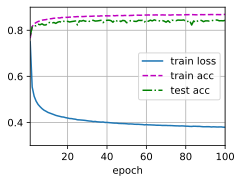

In [5]:
%%time
net.apply(init_weights)
num_epochs = 100
batch_size = 256

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

CPU times: user 9min 39s, sys: 29 s, total: 10min 8s
Wall time: 1min 24s


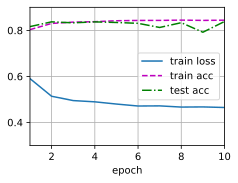

In [6]:
%%time
net.apply(init_weights)
num_epochs = 10
batch_size = 16

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

CPU times: user 3min 7s, sys: 15.6 s, total: 3min 23s
Wall time: 27.4 s


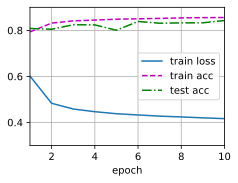

In [7]:
%%time
net.apply(init_weights)
num_epochs = 10
batch_size = 64

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

CPU times: user 1min 59s, sys: 12.5 s, total: 2min 12s
Wall time: 18.8 s


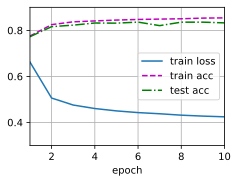

In [8]:
%%time
net.apply(init_weights)
num_epochs = 10
batch_size = 128

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

CPU times: user 1min 14s, sys: 17.2 s, total: 1min 31s
Wall time: 22.6 s


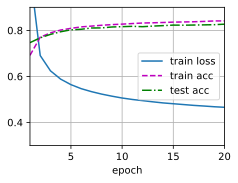

In [9]:
%%time
net.apply(init_weights)
num_epochs = 20
batch_size = 1024

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

CPU times: user 3min 58s, sys: 23.7 s, total: 4min 22s
Wall time: 36.7 s


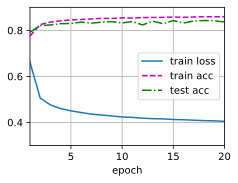

In [10]:
%%time
net.apply(init_weights)
num_epochs = 20
batch_size = 128

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

CPU times: user 1min 23s, sys: 10.2 s, total: 1min 33s
Wall time: 14.7 s


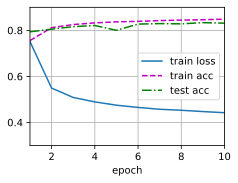

In [12]:
%%time
# 设置损失函数
loss = nn.CrossEntropyLoss(reduction='none')
# 设置优化器
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

net.apply(init_weights)
num_epochs = 10
batch_size = 256

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

1.4727523560841878
CPU times: user 1min 23s, sys: 10.1 s, total: 1min 33s
Wall time: 14.6 s


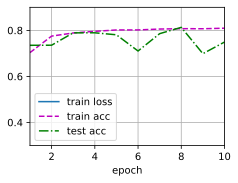

In [15]:
%%time
try:
    # 设置损失函数
    loss = nn.CrossEntropyLoss(reduction='none')
    # 设置优化器
    trainer = torch.optim.SGD(net.parameters(), lr =1)

    net.apply(init_weights);

    num_epochs = 10
    batch_size = 256

    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

    d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
except Exception as e:
    print(e)

1.1938219042460123
CPU times: user 15min 1s, sys: 1min 57s, total: 16min 58s
Wall time: 2min 34s


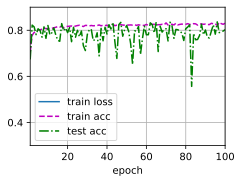

In [16]:
%%time
try:
    # 设置损失函数
    loss = nn.CrossEntropyLoss(reduction='none')
    # 设置优化器
    trainer = torch.optim.SGD(net.parameters(), lr =1)

    net.apply(init_weights)

    num_epochs = 100
    batch_size = 256

    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

    d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
except Exception as e:
    print(e)

0.6380482590357462
CPU times: user 1min 22s, sys: 10.2 s, total: 1min 32s
Wall time: 14.7 s


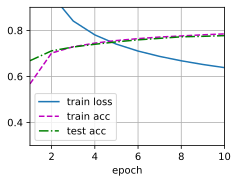

In [17]:
%%time
try:
    # 设置损失函数
    loss = nn.CrossEntropyLoss(reduction='none')
    # 设置优化器
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)

    net.apply(init_weights)

    num_epochs = 10
    batch_size = 256

    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

    d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
except Exception as e:
    print(e)

1.052158075205485
CPU times: user 1min 22s, sys: 11.1 s, total: 1min 33s
Wall time: 14.6 s


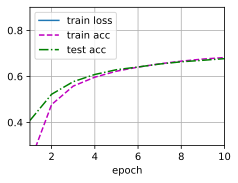

In [18]:
%%time
try:
    # 设置损失函数
    loss = nn.CrossEntropyLoss(reduction='none')
    # 设置优化器
    trainer = torch.optim.SGD(net.parameters(), lr=0.001)

    net.apply(init_weights)

    num_epochs = 10
    batch_size = 256

    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

    d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
except Exception as e:
    print(e)

0.6240836641311646
CPU times: user 13min 50s, sys: 1min 47s, total: 15min 37s
Wall time: 2min 24s


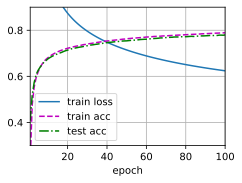

In [19]:
%%time
try:
    # 设置损失函数
    loss = nn.CrossEntropyLoss(reduction='none')
    # 设置优化器
    trainer = torch.optim.SGD(net.parameters(), lr=0.001)

    net.apply(init_weights)

    num_epochs = 100
    batch_size = 256

    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

    d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
except Exception as e:
    print(e)

2.3436632347106934
CPU times: user 1min 22s, sys: 10.1 s, total: 1min 32s
Wall time: 14.6 s


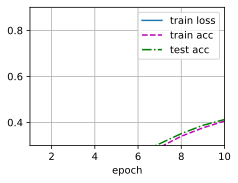

In [20]:
%%time
try:
    # 设置损失函数
    loss = nn.CrossEntropyLoss(reduction='none')
    # 设置优化器
    trainer = torch.optim.SGD(net.parameters(), lr=0.0001)

    net.apply(init_weights)

    num_epochs = 10
    batch_size = 256

    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

    d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
except Exception as e:
    print(e)

&emsp;&emsp;通过实验，我们发现：
1. 学习率越小，收敛越慢，同时可能存在局部收敛的问题，影响训练精度。
2. 轮数越多，一般效果越好，但可能因为训练精度已收敛，会花费不必要的训练时间。
3. `batch_size`越大，训练时间越短，但是可能会影响训练精度，并且`batch_size`与机器相关，使用`GPU`训练时，显存较小可能无法满足大`batch_size`训练。

### 练习二

&emsp;&emsp;增加迭代周期的数量可能会导致过拟合，从而导致测试精度下降。具体来说，当我们增加迭代周期的数量时，模型可能会开始学习到一些只能满足训练样本的非共性特征（这些更多是一种偶然性特征，不适用于测试样本），从而导致过拟合。为了解决这个问题，可以使用早停技术或正则化技术。早停技术是指在模型出现过拟合时（测试集表现开始下降）停止训练。正则化技术是指通过向损失函数添加惩罚项来限制模型参数的大小，从而减少过拟合。

### 练习三

&emsp;&emsp;关于LogSumExp博客有详细讲解